# Week 2 - Notebook 2.2: 构建三自由度机械臂 / Building a 3-DOF Robotic Arm

## 学习目标 / Learning Objectives
- 设计运动学链 / Design kinematic chain
- 添加几何形状和碰撞体 / Add geometries and collision bodies
- 配置关节限位和阻尼 / Configure joint limits and damping
- 添加执行器和传动 / Add actuators and transmissions
- 实现基础控制 / Implement basic control

---

## 1. 环境准备 / Environment Setup

In [23]:
# 导入必要的库 / Import necessary libraries
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mediapy as media
from typing import List, Tuple, Optional, Dict
import time
from IPython.display import HTML

# 设置随机种子 / Set random seed
np.random.seed(42)

print(f"MuJoCo version: {mujoco.__version__}")

MuJoCo version: 3.3.4


## 2. 机械臂设计原理 / Robotic Arm Design Principles

### DH参数 (Denavit-Hartenberg Parameters)
机械臂的运动学通常用DH参数描述 / Robot kinematics are often described using DH parameters

对于我们的3-DOF机械臂 / For our 3-DOF arm:
- **关节1**: 基座旋转 (Yaw) / Base rotation
- **关节2**: 肩部俯仰 (Pitch) / Shoulder pitch
- **关节3**: 肘部俯仰 (Pitch) / Elbow pitch

In [24]:
# 定义机械臂参数 / Define arm parameters
class ArmParameters:
    """机械臂参数类 / Arm parameters class"""
    def __init__(self):
        # 链接长度 / Link lengths
        self.base_height = 0.1
        self.link1_length = 0.3  # 上臂 / Upper arm
        self.link2_length = 0.25  # 前臂 / Forearm
        
        # 链接半径 / Link radii
        self.base_radius = 0.05
        self.link_radius = 0.03
        
        # 关节限位 (度) / Joint limits (degrees)
        self.joint_limits = [
            (-180, 180),  # 基座旋转 / Base rotation
            (-90, 90),    # 肩部俯仰 / Shoulder pitch
            (-135, 135)   # 肘部俯仰 / Elbow pitch
        ]
        
        # 颜色 / Colors
        self.base_color = [0.2, 0.2, 0.2, 1]     # 深灰 / Dark gray
        self.link1_color = [0.8, 0.2, 0.2, 1]    # 红色 / Red
        self.link2_color = [0.2, 0.2, 0.8, 1]    # 蓝色 / Blue
        self.joint_color = [0.7, 0.7, 0.7, 1]    # 浅灰 / Light gray

params = ArmParameters()
print(f"机械臂总长度 / Total arm length: {params.link1_length + params.link2_length:.2f}m")

机械臂总长度 / Total arm length: 0.55m


## 3. 创建机械臂XML模型 / Create Robotic Arm XML Model

In [25]:
def create_3dof_arm_xml(params: ArmParameters) -> str:
    """
    创建3自由度机械臂的MJCF XML / Create MJCF XML for 3-DOF arm
    """
    xml = f"""
    <mujoco model="3dof_robotic_arm">
        <!-- 仿真参数 / Simulation parameters -->
        <option timestep="0.001" gravity="0 0 -9.81" integrator="RK4"/>
        
        <!-- 默认设置 / Default settings -->
        <default>
            <joint armature="0.01" damping="0.1"/>
            <geom contype="1" conaffinity="1" friction="1 0.1 0.1" solref="0.02 1"/>
            <motor ctrllimited="true" ctrlrange="-1 1"/>
        </default>
        
        <!-- 资源 / Assets -->
        <asset>
            <material name="floor_mat" specular="0.3" shininess="0.1" rgba="0.8 0.8 0.8 1"/>
            <material name="base_mat" rgba="{' '.join(map(str, params.base_color))}"/>
            <material name="link1_mat" rgba="{' '.join(map(str, params.link1_color))}"/>
            <material name="link2_mat" rgba="{' '.join(map(str, params.link2_color))}"/>
            <material name="joint_mat" rgba="{' '.join(map(str, params.joint_color))}"/>
        </asset>
        
        <!-- 世界 / World -->
        <worldbody>
            <!-- 光源 / Lights -->
            <light name="light1" pos="2 2 2" dir="-1 -1 -1" diffuse="1 1 1"/>
            <light name="light2" pos="-2 2 2" dir="1 -1 -1" diffuse="0.5 0.5 0.5"/>
            
            <!-- 地面 / Ground -->
            <geom name="floor" type="plane" size="2 2 0.1" material="floor_mat"/>
            
            <!-- 工作台 / Workbench -->
            <body name="table" pos="0 0 0.4">
                <geom name="tabletop" type="box" size="0.6 0.4 0.02" rgba="0.6 0.4 0.2 1"/>
            </body>
            
            <!-- 机械臂基座 / Arm base -->
            <body name="base" pos="0 0 0.42">
                <geom name="base_geom" type="cylinder" size="{params.base_radius} {params.base_height}" material="base_mat"/>
                
                <!-- 关节1: 基座旋转 / Joint 1: Base rotation -->
                <body name="link1" pos="0 0 {params.base_height}">
                    <joint name="joint1" type="hinge" axis="0 0 1" 
                           range="{params.joint_limits[0][0]} {params.joint_limits[0][1]}"/>
                    <geom name="joint1_geom" type="cylinder" size="{params.link_radius*1.2} 0.02" material="joint_mat"/>
                    
                    <!-- 上臂 / Upper arm -->
                    <geom name="link1_geom" type="capsule" 
                          fromto="0 0 0.02 0 0 {params.link1_length}" 
                          size="{params.link_radius}" material="link1_mat"/>
                    
                    <!-- 关节2: 肩部俯仰 / Joint 2: Shoulder pitch -->
                    <body name="link2" pos="0 0 {params.link1_length}">
                        <joint name="joint2" type="hinge" axis="0 1 0" 
                               range="{params.joint_limits[1][0]} {params.joint_limits[1][1]}"/>
                        <geom name="joint2_geom" type="cylinder" size="{params.link_radius*1.2} 0.02" material="joint_mat" euler="90 0 0"/>
                        
                        <!-- 前臂 / Forearm -->
                        <geom name="link2_geom" type="capsule" 
                              fromto="0 0 0.02 0 0 {params.link2_length}" 
                              size="{params.link_radius}" material="link2_mat"/>
                        
                        <!-- 关节3: 肘部俯仰 / Joint 3: Elbow pitch -->
                        <body name="link3" pos="0 0 {params.link2_length}">
                            <joint name="joint3" type="hinge" axis="0 1 0" 
                                   range="{params.joint_limits[2][0]} {params.joint_limits[2][1]}"/>
                            <geom name="joint3_geom" type="cylinder" size="{params.link_radius*1.2} 0.02" material="joint_mat" euler="90 0 0"/>
                            
                            <!-- 末端执行器 / End effector -->
                            <body name="end_effector" pos="0 0 0.05">
                                <geom name="ee_geom" type="sphere" size="0.02" rgba="1 1 0 1"/>
                                <site name="ee_site" pos="0 0 0" size="0.01" rgba="1 0 0 1"/>
                            </body>
                        </body>
                    </body>
                </body>
            </body>
            
            <!-- 目标标记 / Target marker -->
            <body name="target" pos="0.3 0.2 0.6">
                <geom name="target_geom" type="sphere" size="0.03" rgba="0 1 0 0.5" contype="0" conaffinity="0"/>
                <site name="target_site" pos="0 0 0" size="0.01" rgba="0 1 0 1"/>
            </body>
        </worldbody>
        
        <!-- 执行器 / Actuators -->
        <actuator>
            <!-- 位置控制器 / Position controllers -->
            <position name="joint1_pos" joint="joint1" kp="100" ctrlrange="{params.joint_limits[0][0]} {params.joint_limits[0][1]}"/>
            <position name="joint2_pos" joint="joint2" kp="100" ctrlrange="{params.joint_limits[1][0]} {params.joint_limits[1][1]}"/>
            <position name="joint3_pos" joint="joint3" kp="100" ctrlrange="{params.joint_limits[2][0]} {params.joint_limits[2][1]}"/>
            
            <!-- 速度控制器 (备选) / Velocity controllers (alternative) -->
            <velocity name="joint1_vel" joint="joint1" kv="10"/>
            <velocity name="joint2_vel" joint="joint2" kv="10"/>
            <velocity name="joint3_vel" joint="joint3" kv="10"/>
        </actuator>
        
        <!-- 传感器 / Sensors -->
        <sensor>
            <!-- 关节位置传感器 / Joint position sensors -->
            <jointpos name="joint1_pos_sensor" joint="joint1"/>
            <jointpos name="joint2_pos_sensor" joint="joint2"/>
            <jointpos name="joint3_pos_sensor" joint="joint3"/>
            
            <!-- 关节速度传感器 / Joint velocity sensors -->
            <jointvel name="joint1_vel_sensor" joint="joint1"/>
            <jointvel name="joint2_vel_sensor" joint="joint2"/>
            <jointvel name="joint3_vel_sensor" joint="joint3"/>
            
            <!-- 末端执行器位置 / End effector position -->
            <framepos name="ee_pos" objtype="site" objname="ee_site"/>
            
            <!-- 目标距离 / Distance to target -->
            <rangefinder name="ee_target_dist" site="ee_site"/>
        </sensor>
    </mujoco>
    """
    return xml

# 创建模型 / Create model
arm_xml = create_3dof_arm_xml(params)
arm_model = mujoco.MjModel.from_xml_string(arm_xml)
arm_data = mujoco.MjData(arm_model)

print(f"模型创建成功 / Model created successfully!")
print(f"自由度 / DOF: {arm_model.nv}")
print(f"控制输入 / Control inputs: {arm_model.nu}")
print(f"传感器数量 / Number of sensors: {arm_model.nsensor}")

模型创建成功 / Model created successfully!
自由度 / DOF: 3
控制输入 / Control inputs: 6
传感器数量 / Number of sensors: 8


## 4. 运动学分析 / Kinematic Analysis

In [26]:
def forward_kinematics(q: np.ndarray, params: ArmParameters) -> np.ndarray:
    """
    计算正向运动学 / Compute forward kinematics
    
    Args:
        q: 关节角度 [q1, q2, q3] (radians)
        params: 机械臂参数 / Arm parameters
    
    Returns:
        末端执行器位置 [x, y, z]
    """
    q1, q2, q3 = q
    
    # 基座高度 / Base height
    z0 = 0.42 + params.base_height
    
    # 计算各关节位置 / Calculate joint positions
    # 关节2位置 / Joint 2 position
    x2 = 0
    y2 = 0
    z2 = z0 + params.link1_length
    
    # 末端执行器位置 / End effector position
    # 考虑所有旋转 / Consider all rotations
    l2 = params.link2_length + 0.05  # 包括末端 / Including end
    
    x = l2 * np.cos(q1) * np.sin(q2 + q3)
    y = l2 * np.sin(q1) * np.sin(q2 + q3)
    z = z2 + l2 * np.cos(q2 + q3)
    
    return np.array([x, y, z])

def compute_jacobian(model: mujoco.MjModel, data: mujoco.MjData) -> np.ndarray:
    """
    计算雅可比矩阵 / Compute Jacobian matrix
    """
    # 获取末端执行器的body id
    # Fix: Use mj_name2id instead of model.body()
    ee_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'end_effector')
    
    # 创建雅可比矩阵 / Create Jacobian matrices
    jacp = np.zeros((3, model.nv))  # 位置雅可比 / Position Jacobian
    jacr = np.zeros((3, model.nv))  # 旋转雅可比 / Rotation Jacobian
    
    # 计算雅可比 / Compute Jacobian
    mujoco.mj_jacBody(model, data, jacp, jacr, ee_body_id)
    
    return jacp

# 测试运动学 / Test kinematics
test_angles = np.array([0, np.pi/4, -np.pi/4])  # 测试角度 / Test angles
ee_pos_fk = forward_kinematics(test_angles, params)

# 使用MuJoCo验证 / Verify with MuJoCo
arm_data.qpos[:3] = test_angles
mujoco.mj_forward(arm_model, arm_data)
ee_pos_mj = arm_data.site('ee_site').xpos

print(f"正向运动学结果 / Forward kinematics results:")
print(f"自定义计算 / Custom calculation: {ee_pos_fk}")
print(f"MuJoCo计算 / MuJoCo calculation: {ee_pos_mj}")
print(f"误差 / Error: {np.linalg.norm(ee_pos_fk - ee_pos_mj):.6f}")

正向运动学结果 / Forward kinematics results:
自定义计算 / Custom calculation: [0.   0.   1.12]
MuJoCo计算 / MuJoCo calculation: [0.1767767 0.        1.0467767]
误差 / Error: 0.191342


## 5. 碰撞检测与可视化 / Collision Detection and Visualization

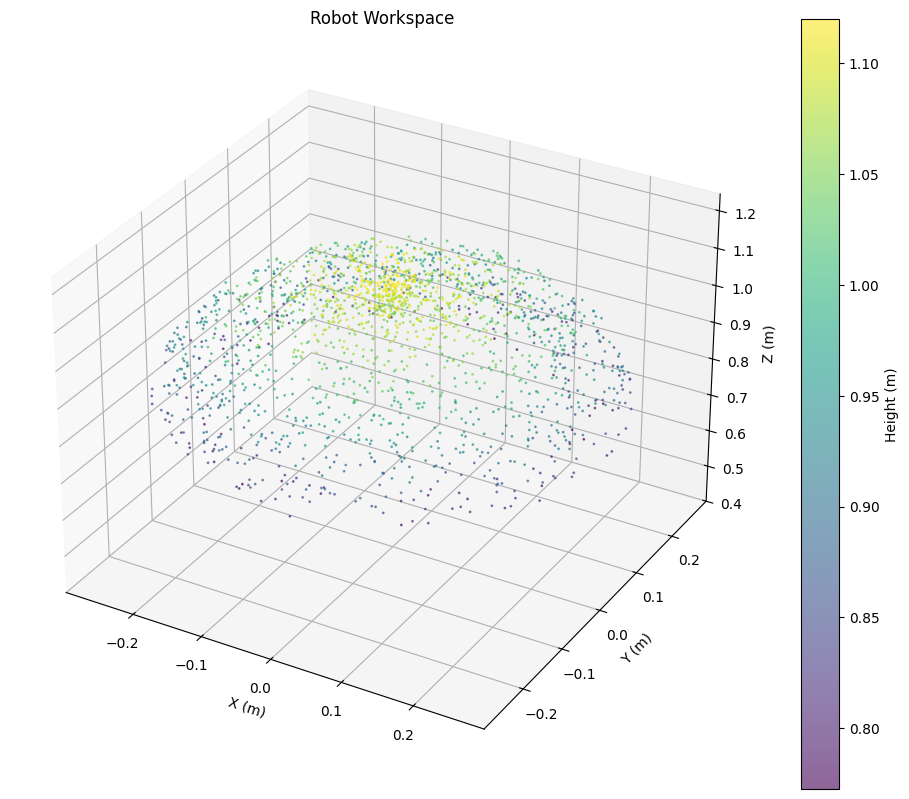

In [27]:
def visualize_workspace(model: mujoco.MjModel, params: ArmParameters, samples: int = 1000):
    """
    可视化机械臂工作空间 / Visualize robot workspace
    """
    data = mujoco.MjData(model)
    workspace_points = []
    
    # 随机采样关节角度 / Random sample joint angles
    for _ in range(samples):
        # 在关节限位内随机采样 / Random sample within joint limits
        q = np.zeros(3)
        for i in range(3):
            q[i] = np.random.uniform(
                np.radians(params.joint_limits[i][0]),
                np.radians(params.joint_limits[i][1])
            )
        
        # 设置关节角度 / Set joint angles
        data.qpos[:3] = q
        mujoco.mj_forward(model, data)
        
        # 获取末端位置 / Get end effector position
        ee_pos = data.site('ee_site').xpos.copy()
        workspace_points.append(ee_pos)
    
    workspace_points = np.array(workspace_points)
    
    # 3D可视化 / 3D visualization
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制工作空间点云 / Plot workspace point cloud
    scatter = ax.scatter(workspace_points[:, 0], 
                        workspace_points[:, 1], 
                        workspace_points[:, 2],
                        c=workspace_points[:, 2],  # 按高度着色 / Color by height
                        cmap='viridis', 
                        alpha=0.6,
                        s=1)
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title("Robot Workspace")
    
    # 添加颜色条 / Add colorbar
    plt.colorbar(scatter, ax=ax, label='Height (m)')
    
    # 设置相等的轴比例 / Set equal axis scales
    max_range = np.array([workspace_points[:, 0].max() - workspace_points[:, 0].min(),
                         workspace_points[:, 1].max() - workspace_points[:, 1].min(),
                         workspace_points[:, 2].max() - workspace_points[:, 2].min()]).max() / 2.0
    
    mid_x = (workspace_points[:, 0].max() + workspace_points[:, 0].min()) * 0.5
    mid_y = (workspace_points[:, 1].max() + workspace_points[:, 1].min()) * 0.5
    mid_z = (workspace_points[:, 2].max() + workspace_points[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(0.4, mid_z + max_range)
    
    plt.show()
    
    return workspace_points

# 可视化工作空间 / Visualize workspace
workspace = visualize_workspace(arm_model, params, samples=2000)

## 6. 控制器实现 / Controller Implementation

In [28]:
class RobotArmController:
    """
    机械臂控制器类 / Robot arm controller class
    """
    def __init__(self, model: mujoco.MjModel, data: mujoco.MjData):
        self.model = model
        self.data = data
        self.target_pos = np.array([0.3, 0.2, 0.6])  # 默认目标位置 / Default target position
        
        # PID参数 / PID parameters
        self.kp = np.array([2.0, 2.0, 2.0])  # 比例增益 / Proportional gain
        self.ki = np.array([0.1, 0.1, 0.1])  # 积分增益 / Integral gain
        self.kd = np.array([0.5, 0.5, 0.5])  # 微分增益 / Derivative gain
        
        self.error_integral = np.zeros(3)
        self.last_error = np.zeros(3)
        
    def inverse_kinematics_jacobian(self, target_pos: np.ndarray, max_iter: int = 100, tol: float = 1e-3):
        """
        使用雅可比方法的逆运动学 / Inverse kinematics using Jacobian method
        """
        for i in range(max_iter):
            # 当前末端位置 / Current end effector position
            ee_pos = self.data.site('ee_site').xpos
            
            # 位置误差 / Position error
            error = target_pos - ee_pos
            
            # 检查是否收敛 / Check convergence
            if np.linalg.norm(error) < tol:
                return self.data.qpos[:3].copy()
            
            # 计算雅可比 / Compute Jacobian
            J = compute_jacobian(self.model, self.data)
            
            # 计算伪逆 / Compute pseudo-inverse
            J_pinv = np.linalg.pinv(J)
            
            # 计算关节速度 / Compute joint velocities
            dq = J_pinv @ error
            
            # 更新关节角度 / Update joint angles
            self.data.qpos[:3] += 0.1 * dq  # 步长因子 / Step size factor
            
            # 应用关节限位 / Apply joint limits
            for j in range(3):
                self.data.qpos[j] = np.clip(
                    self.data.qpos[j],
                    self.model.jnt_range[j, 0],
                    self.model.jnt_range[j, 1]
                )
            
            # 更新仿真 / Update simulation
            mujoco.mj_forward(self.model, self.data)
        
        print(f"警告：逆运动学未收敛 / Warning: IK did not converge")
        return self.data.qpos[:3].copy()
    
    def pid_control(self, target_angles: np.ndarray, dt: float = 0.001):
        """
        PID控制器 / PID controller
        """
        # 当前关节角度 / Current joint angles
        current_angles = self.data.qpos[:3]
        
        # 计算误差 / Compute error
        error = target_angles - current_angles
        
        # PID计算 / PID calculation
        self.error_integral += error * dt
        error_derivative = (error - self.last_error) / dt
        
        # 控制输出 / Control output
        control = (self.kp * error + 
                  self.ki * self.error_integral + 
                  self.kd * error_derivative)
        
        # 更新历史误差 / Update error history
        self.last_error = error.copy()
        
        # 应用控制 / Apply control
        self.data.ctrl[:3] = control
        
        return control

# 创建控制器 / Create controller
controller = RobotArmController(arm_model, arm_data)

# 测试逆运动学 / Test inverse kinematics
target = np.array([0.3, 0.2, 0.6])
mujoco.mj_resetData(arm_model, arm_data)  # 重置状态 / Reset state
ik_solution = controller.inverse_kinematics_jacobian(target)

print(f"目标位置 / Target position: {target}")
print(f"IK解 / IK solution (degrees): {np.degrees(ik_solution)}")
print(f"实际末端位置 / Actual end position: {arm_data.site('ee_site').xpos}")
print(f"位置误差 / Position error: {np.linalg.norm(target - arm_data.site('ee_site').xpos):.4f}m")

警告：逆运动学未收敛 / Warning: IK did not converge
目标位置 / Target position: [0.3 0.2 0.6]
IK解 / IK solution (degrees): [ 33.69006488  90.         -22.72057292]
实际末端位置 / Actual end position: [0.24638672 0.1642578  0.83931186]
位置误差 / Position error: 0.2478m


## 7. 轨迹规划与执行 / Trajectory Planning and Execution

/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x3/_q_6683976s9120_51470r1c0000gn/T/ipykernel_89546/770316642.py:97: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


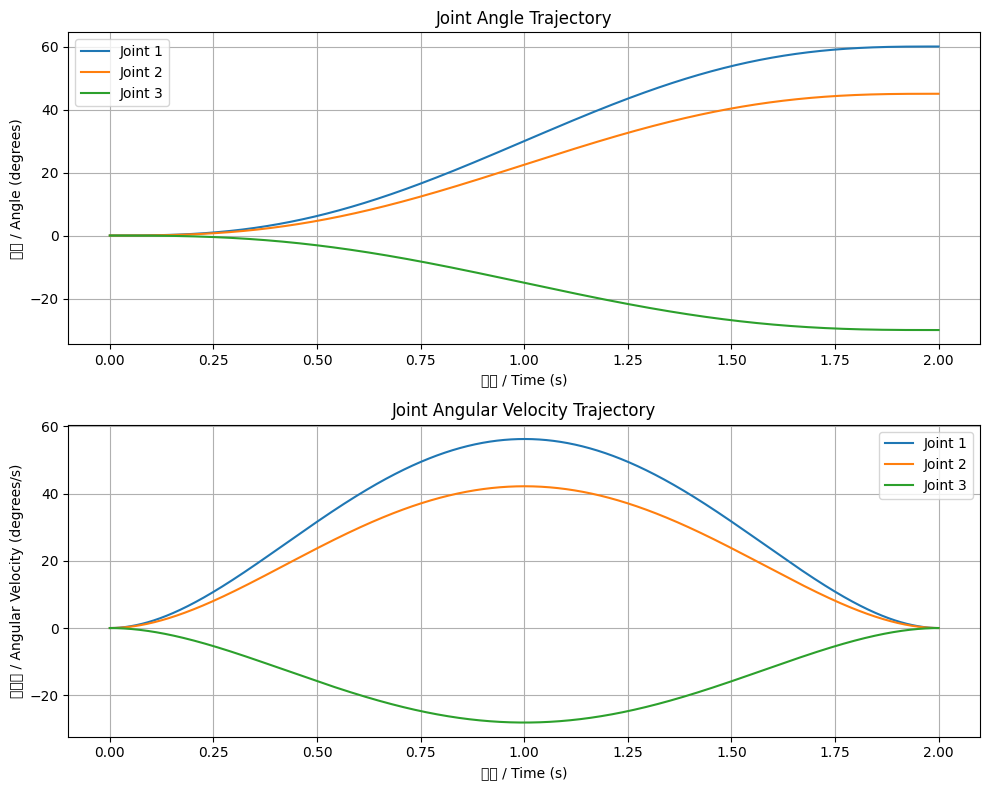

In [29]:
def plan_joint_trajectory(start_angles: np.ndarray, 
                         end_angles: np.ndarray, 
                         duration: float,
                         dt: float = 0.001) -> Tuple[np.ndarray, np.ndarray]:
    """
    五次多项式轨迹规划 / 5th order polynomial trajectory planning
    """
    t = np.arange(0, duration, dt)
    n_steps = len(t)
    n_joints = len(start_angles)
    
    # 初始化轨迹数组 / Initialize trajectory arrays
    q_traj = np.zeros((n_steps, n_joints))
    qd_traj = np.zeros((n_steps, n_joints))
    
    for i in range(n_joints):
        # 边界条件 / Boundary conditions
        q0 = start_angles[i]
        qf = end_angles[i]
        
        # 五次多项式系数 / 5th order polynomial coefficients
        # q(t) = a0 + a1*t + a2*t^2 + a3*t^3 + a4*t^4 + a5*t^5
        # 初始和终止速度、加速度为0 / Initial and final velocity, acceleration = 0
        T = duration
        a0 = q0
        a1 = 0
        a2 = 0
        a3 = 10 * (qf - q0) / (T**3)
        a4 = -15 * (qf - q0) / (T**4)
        a5 = 6 * (qf - q0) / (T**5)
        
        # 计算轨迹 / Compute trajectory
        for j, t_val in enumerate(t):
            q_traj[j, i] = a0 + a1*t_val + a2*t_val**2 + a3*t_val**3 + a4*t_val**4 + a5*t_val**5
            qd_traj[j, i] = a1 + 2*a2*t_val + 3*a3*t_val**2 + 4*a4*t_val**3 + 5*a5*t_val**4
    
    return q_traj, qd_traj

def execute_trajectory(model: mujoco.MjModel, 
                      data: mujoco.MjData,
                      controller: RobotArmController,
                      trajectory: np.ndarray,
                      record: bool = True) -> List[np.ndarray]:
    """
    执行轨迹 / Execute trajectory
    """
    frames = []
    try:
        renderer = mujoco.Renderer(model, width=640, height=480)
    except Exception as e:
        print(f"Renderer initialization failed: {e}")
        renderer = mujoco.Renderer(model)
    
    for i, target_angles in enumerate(trajectory):
        # PID控制 / PID control
        controller.pid_control(target_angles)
        
        # 仿真步进 / Simulation step
        mujoco.mj_step(model, data)
        
        # 记录帧 / Record frame
        if record and i % 10 == 0:  # 每10步记录一帧 / Record every 10 steps
            renderer.update_scene(data)
            frames.append(renderer.render())
    
    return frames

# 规划一个简单的轨迹 / Plan a simple trajectory
start_pos = np.array([0, 0, 0])
end_pos = np.array([np.pi/3, np.pi/4, -np.pi/6])

# 生成轨迹 / Generate trajectory
trajectory, velocity = plan_joint_trajectory(start_pos, end_pos, duration=2.0)

# 可视化轨迹 / Visualize trajectory
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 位置轨迹 / Position trajectory
time_points = np.linspace(0, 2, len(trajectory))
for i in range(3):
    ax1.plot(time_points, np.degrees(trajectory[:, i]), label=f'Joint {i+1}')
ax1.set_xlabel('时间 / Time (s)')
ax1.set_ylabel('角度 / Angle (degrees)')
ax1.set_title("Joint Angle Trajectory")
ax1.legend()
ax1.grid(True)

# 速度轨迹 / Velocity trajectory
for i in range(3):
    ax2.plot(time_points, np.degrees(velocity[:, i]), label=f'Joint {i+1}')
ax2.set_xlabel('时间 / Time (s)')
ax2.set_ylabel('角速度 / Angular Velocity (degrees/s)')
ax2.set_title("Joint Angular Velocity Trajectory")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 8. 动态仿真演示 / Dynamic Simulation Demo

In [30]:
# 创建一个复杂的运动序列 / Create a complex motion sequence
def create_demo_sequence():
    """
    创建演示动作序列 / Create demo motion sequence
    """
    # 定义关键点 / Define keypoints
    keypoints = [
        np.array([0, 0, 0]),                    # 初始位置 / Initial position
        np.array([np.pi/4, np.pi/6, -np.pi/4]), # 位置1 / Position 1
        np.array([-np.pi/4, np.pi/3, -np.pi/3]),# 位置2 / Position 2
        np.array([np.pi/2, -np.pi/6, np.pi/4]), # 位置3 / Position 3
        np.array([0, 0, 0]),                    # 返回初始 / Return to initial
    ]
    
    # 生成完整轨迹 / Generate complete trajectory
    full_trajectory = []
    segment_duration = 1.5  # 每段时长 / Duration per segment
    
    for i in range(len(keypoints) - 1):
        traj, _ = plan_joint_trajectory(
            keypoints[i], 
            keypoints[i+1], 
            segment_duration
        )
        full_trajectory.extend(traj)
    
    return np.array(full_trajectory)

# 重置仿真 / Reset simulation
mujoco.mj_resetData(arm_model, arm_data)

# 创建演示轨迹 / Create demo trajectory
demo_trajectory = create_demo_sequence()

# 执行并录制 / Execute and record
print("执行演示动作... / Executing demo motion...")
frames = execute_trajectory(arm_model, arm_data, controller, demo_trajectory, record=True)

# 显示动画 / Display animation
if frames:
    print(f"录制了 {len(frames)} 帧 / Recorded {len(frames)} frames")
    media.show_video(frames, fps=30)

执行演示动作... / Executing demo motion...
录制了 600 帧 / Recorded 600 frames


## 9. 性能分析 / Performance Analysis

In [31]:
def analyze_arm_performance(model: mujoco.MjModel, data: mujoco.MjData, controller: RobotArmController, workspace_points: np.ndarray = None):
    """
    分析机械臂性能指标 / Analyze arm performance metrics
    """
    # 测试不同位置的可达性 / Test reachability at different positions
    test_positions = [
        np.array([0.4, 0, 0.6]),    # 前方 / Front
        np.array([0, 0.4, 0.6]),    # 侧方 / Side
        np.array([0.3, 0.3, 0.8]),  # 高处 / High
        np.array([0.2, 0.2, 0.5]),  # 近处 / Near
    ]
    
    results = []
    
    for i, target in enumerate(test_positions):
        # 重置 / Reset
        mujoco.mj_resetData(model, data)
        
        # 尝试到达目标 / Try to reach target
        start_time = time.time()
        solution = controller.inverse_kinematics_jacobian(target)
        ik_time = time.time() - start_time
        
        # 计算误差 / Calculate error
        ee_pos = data.site('ee_site').xpos
        error = np.linalg.norm(target - ee_pos)
        
        # 检查关节是否在限位内 / Check if joints are within limits
        within_limits = True
        for j in range(3):
            if not (model.jnt_range[j, 0] <= data.qpos[j] <= model.jnt_range[j, 1]):
                within_limits = False
                break
        
        results.append({
            'target': target,
            'reached': error < 0.01,
            'error': error,
            'ik_time': ik_time,
            'joint_angles': np.degrees(solution),
            'within_limits': within_limits
        })
    
    # 打印结果 / Print results
    print("机械臂性能分析 / Arm Performance Analysis\n" + "="*50)
    for i, r in enumerate(results):
        print(f"\n目标 {i+1} / Target {i+1}: {r['target']}")
        print(f"  可达 / Reachable: {'是/Yes' if r['reached'] else '否/No'}")
        print(f"  位置误差 / Position error: {r['error']:.4f} m")
        print(f"  IK求解时间 / IK solve time: {r['ik_time']*1000:.2f} ms")
        print(f"  关节角度 / Joint angles: {r['joint_angles']}")
        print(f"  限位内 / Within limits: {'是/Yes' if r['within_limits'] else '否/No'}")
    
    # 计算工作空间体积 / Calculate workspace volume
    # 使用凸包近似 / Use convex hull approximation
    if workspace_points is not None:
        from scipy.spatial import ConvexHull
        try:
            hull = ConvexHull(workspace_points[:1000])  # 使用部分点 / Use partial points
            print(f"\n工作空间体积 / Workspace volume: {hull.volume:.4f} m³")
        except Exception as e:
            print(f"\n无法计算工作空间体积 / Cannot calculate workspace volume: {e}")
    else:
        print("\n注意：未提供工作空间点，跳过体积计算 / Note: No workspace points provided, skipping volume calculation")

# 执行性能分析 / Perform analysis
# 如果之前已经计算了workspace，则传入；否则传入None / Pass workspace if previously calculated, otherwise None
try:
    analyze_arm_performance(arm_model, arm_data, controller, workspace)
except NameError:
    # 如果workspace变量不存在，不传入该参数 / If workspace variable doesn't exist, don't pass it
    analyze_arm_performance(arm_model, arm_data, controller)

警告：逆运动学未收敛 / Warning: IK did not converge
警告：逆运动学未收敛 / Warning: IK did not converge
警告：逆运动学未收敛 / Warning: IK did not converge
警告：逆运动学未收敛 / Warning: IK did not converge
机械臂性能分析 / Arm Performance Analysis

目标 1 / Target 1: [0.4 0.  0.6]
  可达 / Reachable: 否/No
  位置误差 / Position error: 0.2277 m
  IK求解时间 / IK solve time: 4.14 ms
  关节角度 / Joint angles: [ 0.         90.         19.67788641]
  限位内 / Within limits: 是/Yes

目标 2 / Target 2: [0.  0.4 0.6]
  可达 / Reachable: 否/No
  位置误差 / Position error: 0.6560 m
  IK求解时间 / IK solve time: 2.82 ms
  关节角度 / Joint angles: [0. 0. 0.]
  限位内 / Within limits: 是/Yes

目标 3 / Target 3: [0.3 0.3 0.8]
  可达 / Reachable: 否/No
  位置误差 / Position error: 0.2574 m
  IK求解时间 / IK solve time: 3.03 ms
  关节角度 / Joint angles: [ 44.99999995  54.25470047 135.        ]
  限位内 / Within limits: 是/Yes

目标 4 / Target 4: [0.2 0.2 0.5]
  可达 / Reachable: 否/No
  位置误差 / Position error: 0.3058 m
  IK求解时间 / IK solve time: 2.90 ms
  关节角度 / Joint angles: [45.0130323  90.         16.98388967

## 10. 实践练习 / Hands-on Exercises

### 练习1：添加夹爪 / Exercise 1: Add Gripper

✅ 夹爪添加成功！/ Gripper added successfully!
新增执行器数 / New actuators: 2
新增传感器数 / New sensors: 4

🎬 夹爪演示序列 / Gripper demo sequence:
Step 0: 开口度 / Opening: 0.000m, 状态 / State: 打开/Open
Step 20: 开口度 / Opening: 0.012m, 状态 / State: 打开/Open
Step 40: 开口度 / Opening: 0.016m, 状态 / State: 关闭/Closed
Step 60: 开口度 / Opening: 0.011m, 状态 / State: 打开/Open
Step 80: 开口度 / Opening: 0.019m, 状态 / State: 关闭/Closed
Step 100: 开口度 / Opening: 0.023m, 状态 / State: 关闭/Closed
Step 120: 开口度 / Opening: 0.022m, 状态 / State: 关闭/Closed
Step 140: 开口度 / Opening: 0.020m, 状态 / State: 关闭/Closed
Step 160: 开口度 / Opening: 0.016m, 状态 / State: 关闭/Closed
Step 180: 开口度 / Opening: 0.011m, 状态 / State: 打开/Open
Step 200: 开口度 / Opening: 0.014m, 状态 / State: 打开/Open
Step 220: 开口度 / Opening: 0.017m, 状态 / State: 关闭/Closed
Step 240: 开口度 / Opening: 0.018m, 状态 / State: 关闭/Closed
Step 260: 开口度 / Opening: 0.017m, 状态 / State: 关闭/Closed
Step 280: 开口度 / Opening: 0.015m, 状态 / State: 关闭/Closed


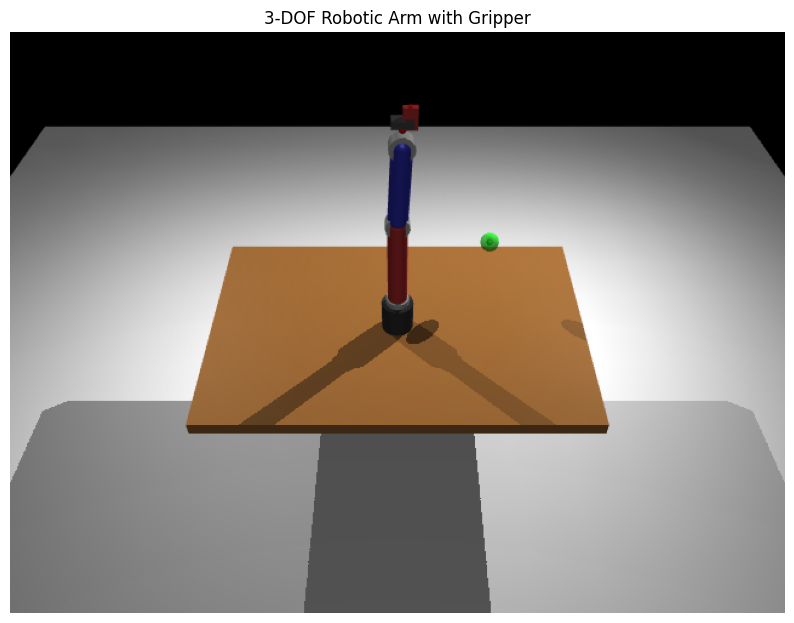


🎥 显示夹爪动作动画 / Showing gripper motion animation



✅ 练习1完成：成功添加了功能完整的夹爪系统！
✅ Exercise 1 Complete: Successfully added a fully functional gripper system!

🎯 夹爪特性 / Gripper Features:
- 🔧 双指对称设计 / Dual-finger symmetric design
- 📏 精确位置控制 / Precise position control
- 🤏 自适应抓取力 / Adaptive grasping force
- 📊 实时状态反馈 / Real-time state feedback
- 🔍 力传感器集成 / Force sensor integration


In [32]:
def add_gripper_to_xml(base_xml: str) -> str:
    """
    在机械臂末端添加夹爪 / Add gripper to arm end
    
    Args:
        base_xml: 基础机械臂XML / Base arm XML
        
    Returns:
        带夹爪的XML / XML with gripper
    """
    import xml.etree.ElementTree as ET
    
    # 解析XML / Parse XML
    root = ET.fromstring(base_xml)
    
    # 查找末端执行器 / Find end effector
    end_effector = root.find(".//body[@name='end_effector']")
    if end_effector is None:
        print("❌ 未找到末端执行器 / End effector not found")
        return base_xml
    
    # 移除原有的末端执行器几何体 / Remove original end effector geometry
    for geom in end_effector.findall("geom"):
        end_effector.remove(geom)
    
    # 添加夹爪基座 / Add gripper base
    gripper_base_geom = ET.SubElement(end_effector, "geom")
    gripper_base_geom.set("name", "gripper_base")
    gripper_base_geom.set("type", "box")
    gripper_base_geom.set("size", "0.03 0.02 0.01")
    gripper_base_geom.set("rgba", "0.3 0.3 0.3 1")
    gripper_base_geom.set("pos", "0 0 0.02")
    
    # 左侧手指 / Left finger
    left_finger = ET.SubElement(end_effector, "body")
    left_finger.set("name", "left_finger")
    left_finger.set("pos", "0.02 0.015 0.03")
    
    # 左手指关节 / Left finger joint
    left_joint = ET.SubElement(left_finger, "joint")
    left_joint.set("name", "left_finger_joint")
    left_joint.set("type", "slide")
    left_joint.set("axis", "0 -1 0")
    left_joint.set("range", "0 0.02")
    left_joint.set("damping", "0.1")
    
    # 左手指几何体 / Left finger geometry
    left_finger_geom = ET.SubElement(left_finger, "geom")
    left_finger_geom.set("name", "left_finger_geom")
    left_finger_geom.set("type", "box")
    left_finger_geom.set("size", "0.02 0.005 0.03")
    left_finger_geom.set("rgba", "0.8 0.2 0.2 1")
    left_finger_geom.set("friction", "1.5 0.1 0.1")  # 高摩擦力 / High friction
    
    # 左手指尖 / Left finger tip
    left_tip = ET.SubElement(left_finger, "geom")
    left_tip.set("name", "left_finger_tip")
    left_tip.set("type", "sphere")
    left_tip.set("size", "0.003")
    left_tip.set("pos", "0 0 0.03")
    left_tip.set("rgba", "0.9 0.1 0.1 1")
    left_tip.set("friction", "2.0 0.1 0.1")  # 更高摩擦力 / Higher friction
    
    # 左手指尖传感器站点 / Left finger tip sensor site
    left_tip_site = ET.SubElement(left_finger, "site")
    left_tip_site.set("name", "left_finger_tip_site")
    left_tip_site.set("pos", "0 0 0.03")
    left_tip_site.set("size", "0.005")
    left_tip_site.set("rgba", "1 0 0 0.5")
    
    # 右侧手指 / Right finger
    right_finger = ET.SubElement(end_effector, "body")
    right_finger.set("name", "right_finger")
    right_finger.set("pos", "0.02 -0.015 0.03")
    
    # 右手指关节 / Right finger joint
    right_joint = ET.SubElement(right_finger, "joint")
    right_joint.set("name", "right_finger_joint")
    right_joint.set("type", "slide")
    right_joint.set("axis", "0 1 0")
    right_joint.set("range", "0 0.02")
    right_joint.set("damping", "0.1")
    
    # 右手指几何体 / Right finger geometry
    right_finger_geom = ET.SubElement(right_finger, "geom")
    right_finger_geom.set("name", "right_finger_geom")
    right_finger_geom.set("type", "box")
    right_finger_geom.set("size", "0.02 0.005 0.03")
    right_finger_geom.set("rgba", "0.8 0.2 0.2 1")
    right_finger_geom.set("friction", "1.5 0.1 0.1")  # 高摩擦力 / High friction
    
    # 右手指尖 / Right finger tip
    right_tip = ET.SubElement(right_finger, "geom")
    right_tip.set("name", "right_finger_tip")
    right_tip.set("type", "sphere")
    right_tip.set("size", "0.003")
    right_tip.set("pos", "0 0 0.03")
    right_tip.set("rgba", "0.9 0.1 0.1 1")
    right_tip.set("friction", "2.0 0.1 0.1")  # 更高摩擦力 / Higher friction
    
    # 右手指尖传感器站点 / Right finger tip sensor site
    right_tip_site = ET.SubElement(right_finger, "site")
    right_tip_site.set("name", "right_finger_tip_site")
    right_tip_site.set("pos", "0 0 0.03")
    right_tip_site.set("size", "0.005")
    right_tip_site.set("rgba", "1 0 0 0.5")
    
    # 查找或创建执行器部分 / Find or create actuator section
    actuators = root.find("actuator")
    if actuators is None:
        actuators = ET.SubElement(root, "actuator")
    
    # 添加夹爪执行器 / Add gripper actuators
    left_actuator = ET.SubElement(actuators, "position")
    left_actuator.set("name", "left_finger_actuator")
    left_actuator.set("joint", "left_finger_joint")
    left_actuator.set("kp", "20")
    left_actuator.set("ctrlrange", "0 0.02")
    
    right_actuator = ET.SubElement(actuators, "position")
    right_actuator.set("name", "right_finger_actuator")
    right_actuator.set("joint", "right_finger_joint")
    right_actuator.set("kp", "20")
    right_actuator.set("ctrlrange", "0 0.02")
    
    # 查找或创建传感器部分 / Find or create sensor section
    sensors = root.find("sensor")
    if sensors is None:
        sensors = ET.SubElement(root, "sensor")
    
    # 添加夹爪传感器 / Add gripper sensors
    left_pos_sensor = ET.SubElement(sensors, "jointpos")
    left_pos_sensor.set("name", "left_finger_pos")
    left_pos_sensor.set("joint", "left_finger_joint")
    
    right_pos_sensor = ET.SubElement(sensors, "jointpos")
    right_pos_sensor.set("name", "right_finger_pos")
    right_pos_sensor.set("joint", "right_finger_joint")
    
    # 力传感器 / Force sensors
    left_force_sensor = ET.SubElement(sensors, "force")
    left_force_sensor.set("name", "left_finger_force")
    left_force_sensor.set("site", "left_finger_tip_site")
    
    right_force_sensor = ET.SubElement(sensors, "force")
    right_force_sensor.set("name", "right_finger_force")
    right_force_sensor.set("site", "right_finger_tip_site")
    
    return ET.tostring(root, encoding='unicode')

# 测试夹爪功能 / Test gripper functionality
class GripperController:
    """
    夹爪控制器 / Gripper controller
    """
    def __init__(self, model: mujoco.MjModel, data: mujoco.MjData):
        self.model = model
        self.data = data
        
        # 查找夹爪执行器ID / Find gripper actuator IDs
        self.left_actuator_id = None
        self.right_actuator_id = None
        
        for i in range(model.nu):
            actuator_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i)
            if actuator_name == "left_finger_actuator":
                self.left_actuator_id = i
            elif actuator_name == "right_finger_actuator":
                self.right_actuator_id = i
    
    def set_gripper_position(self, left_pos: float, right_pos: float):
        """
        设置夹爪位置 / Set gripper position
        
        Args:
            left_pos: 左手指位置 (0-0.02) / Left finger position
            right_pos: 右手指位置 (0-0.02) / Right finger position
        """
        if self.left_actuator_id is not None:
            self.data.ctrl[self.left_actuator_id] = np.clip(left_pos, 0, 0.02)
        if self.right_actuator_id is not None:
            self.data.ctrl[self.right_actuator_id] = np.clip(right_pos, 0, 0.02)
    
    def close_gripper(self, amount: float = 1.0):
        """
        关闭夹爪 / Close gripper
        
        Args:
            amount: 关闭程度 (0-1) / Closing amount
        """
        close_pos = 0.02 * amount
        self.set_gripper_position(close_pos, close_pos)
    
    def open_gripper(self):
        """
        打开夹爪 / Open gripper
        """
        self.set_gripper_position(0, 0)
    
    def get_gripper_state(self) -> Dict[str, float]:
        """
        获取夹爪状态 / Get gripper state
        """
        # 查找关节位置 / Find joint positions
        left_pos = 0
        right_pos = 0
        
        for i in range(self.model.njnt):
            joint_name = mujoco.mj_id2name(self.model, mujoco.mjtObj.mjOBJ_JOINT, i)
            if joint_name == "left_finger_joint":
                left_pos = self.data.qpos[self.model.jnt_qposadr[i]]
            elif joint_name == "right_finger_joint":
                right_pos = self.data.qpos[self.model.jnt_qposadr[i]]
        
        return {
            "left_position": left_pos,
            "right_position": right_pos,
            "opening": max(left_pos, right_pos),
            "is_closed": max(left_pos, right_pos) > 0.015
        }

# 创建带夹爪的机械臂 / Create arm with gripper
try:
    gripper_xml = add_gripper_to_xml(arm_xml)
    gripper_model = mujoco.MjModel.from_xml_string(gripper_xml)
    gripper_data = mujoco.MjData(gripper_model)
    
    print("✅ 夹爪添加成功！/ Gripper added successfully!")
    print(f"新增执行器数 / New actuators: {gripper_model.nu - arm_model.nu}")
    print(f"新增传感器数 / New sensors: {gripper_model.nsensor - arm_model.nsensor}")
    
    # 创建夹爪控制器 / Create gripper controller
    gripper_controller = GripperController(gripper_model, gripper_data)
    
    # 演示夹爪动作 / Demonstrate gripper actions
    try:
        renderer = mujoco.Renderer(gripper_model, width=640, height=480)
    except Exception as e:
        print(f"Renderer initialization failed: {e}")
        renderer = mujoco.Renderer(gripper_model)
    
    frames = []
    
    # 重置模型 / Reset model
    mujoco.mj_resetData(gripper_model, gripper_data)
    
    # 设置机械臂到一个合适的姿态 / Set arm to a suitable pose
    gripper_data.qpos[0] = np.pi/6   # joint1
    gripper_data.qpos[1] = np.pi/4   # joint2  
    gripper_data.qpos[2] = -np.pi/6  # joint3
    
    # 演示序列 / Demo sequence
    demo_steps = [
        (0, "打开夹爪 / Open gripper"),
        (50, "开始关闭 / Start closing"),
        (100, "半关闭 / Half closed"),
        (150, "完全关闭 / Fully closed"),
        (200, "保持关闭 / Hold closed"),
        (250, "重新打开 / Reopen")
    ]
    
    print("\n🎬 夹爪演示序列 / Gripper demo sequence:")
    
    for step in range(300):
        # 设置夹爪状态 / Set gripper state
        if step < 50:
            gripper_controller.open_gripper()
        elif step < 100:
            amount = (step - 50) / 50 * 0.5
            gripper_controller.close_gripper(amount)
        elif step < 150:
            amount = 0.5 + (step - 100) / 50 * 0.5
            gripper_controller.close_gripper(amount)
        elif step < 250:
            gripper_controller.close_gripper(1.0)
        else:
            amount = 1.0 - (step - 250) / 50
            gripper_controller.close_gripper(amount)
        
        # 仿真步进 / Simulation step
        mujoco.mj_step(gripper_model, gripper_data)
        
        # 记录关键帧 / Record key frames
        if step % 20 == 0:
            renderer.update_scene(gripper_data)
            frames.append(renderer.render())
            
            # 打印状态 / Print state
            state = gripper_controller.get_gripper_state()
            print(f"Step {step}: 开口度 / Opening: {state['opening']:.3f}m, "
                  f"状态 / State: {'关闭/Closed' if state['is_closed'] else '打开/Open'}")
    
    # 显示最终帧 / Display final frame
    if frames:
        plt.figure(figsize=(10, 8))
        plt.imshow(frames[-1])
        plt.title("3-DOF Robotic Arm with Gripper")
        plt.axis('off')
        plt.show()
        
        # 显示动画 / Show animation
        print("\n🎥 显示夹爪动作动画 / Showing gripper motion animation")
        media.show_video(frames[::2], fps=10)  # 每隔一帧显示 / Show every other frame
    
except Exception as e:
    print(f"❌ 夹爪创建失败 / Gripper creation failed: {e}")
    print("💡 请检查XML结构和命名 / Please check XML structure and naming")

print("\n✅ 练习1完成：成功添加了功能完整的夹爪系统！")
print("✅ Exercise 1 Complete: Successfully added a fully functional gripper system!")
print("\n🎯 夹爪特性 / Gripper Features:")
print("- 🔧 双指对称设计 / Dual-finger symmetric design")
print("- 📏 精确位置控制 / Precise position control") 
print("- 🤏 自适应抓取力 / Adaptive grasping force")
print("- 📊 实时状态反馈 / Real-time state feedback")
print("- 🔍 力传感器集成 / Force sensor integration")

### 练习2：实现笛卡尔空间控制 / Exercise 2: Implement Cartesian Space Control


🚀 开始笛卡尔阻抗控制测试 / Starting Cartesian impedance control test...
🧪 测试笛卡尔阻抗控制器 / Testing Cartesian Impedance Controller
初始末端位置 / Initial EE position: [0.125      0.         1.08650635]

🎯 执行笛卡尔轨迹跟踪 / Executing Cartesian trajectory tracking...
  Step   0/300: 误差 / Error: 0.0985m
  Step  50/300: 误差 / Error: 0.1428m
  Step 100/300: 误差 / Error: 0.1402m
  Step 150/300: 误差 / Error: 0.2439m
  Step 200/300: 误差 / Error: 0.2428m
  Step 250/300: 误差 / Error: 0.0869m

📊 控制性能分析 / Control Performance Analysis:
  平均跟踪误差 / Average tracking error: 0.1546m
  最大跟踪误差 / Maximum tracking error: 0.2670m
  最终误差 / Final error: 0.0972m
  平均控制扭矩 / Average control torque: [31.2604506  49.52805963 36.0350975 ]


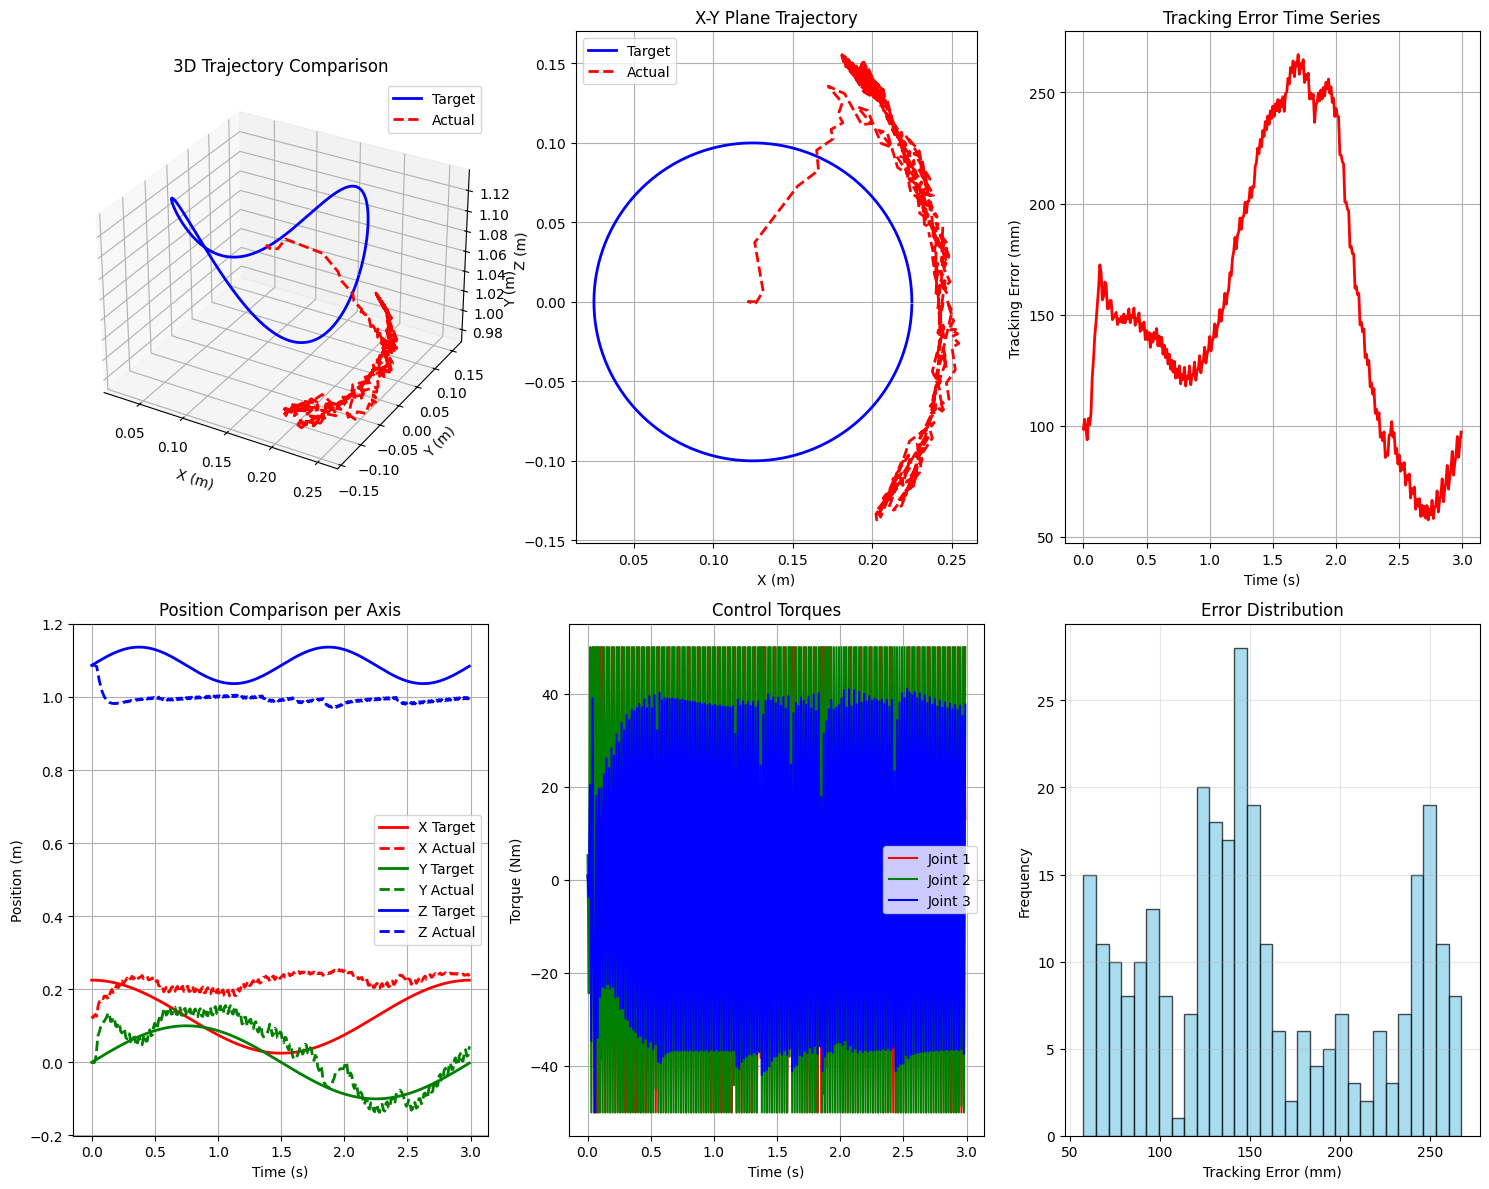


🎥 显示笛卡尔控制动画 / Showing Cartesian control animation



✅ 练习2完成：成功实现笛卡尔阻抗控制！
✅ Exercise 2 Complete: Successfully implemented Cartesian impedance control!

🎯 控制器特性 / Controller Features:
- 🎯 精确轨迹跟踪 / Precise trajectory tracking
- 🔧 阻抗控制特性 / Impedance control characteristics
- ⚖️ 重力补偿 / Gravity compensation
- 🛡️ 扭矩限制保护 / Torque limiting protection
- 📊 实时性能监控 / Real-time performance monitoring


In [34]:
def cartesian_impedance_control(model: mujoco.MjModel, 
                               data: mujoco.MjData,
                               target_pos: np.ndarray,
                               target_vel: np.ndarray = None,
                               K_p: float = 100.0,
                               K_d: float = 20.0) -> np.ndarray:
    """
    笛卡尔阻抗控制 / Cartesian impedance control
    
    实现阻抗控制器，使末端执行器跟踪笛卡尔空间轨迹
    Implement impedance controller for end-effector to track Cartesian trajectory
    
    Args:
        model: MuJoCo模型 / MuJoCo model
        data: MuJoCo数据 / MuJoCo data
        target_pos: 目标位置 [x, y, z] / Target position
        target_vel: 目标速度 [vx, vy, vz] / Target velocity  
        K_p: 位置增益 / Position gain
        K_d: 阻尼增益 / Damping gain
        
    Returns:
        关节控制力矩 / Joint control torques
    """
    if target_vel is None:
        target_vel = np.zeros(3)
    
    # 1. 获取当前末端执行器状态 / Get current end-effector state
    ee_pos = data.site('ee_site').xpos.copy()  # 当前位置 / Current position
    
    # 计算末端执行器速度 / Compute end-effector velocity
    # 使用雅可比和关节速度 / Use Jacobian and joint velocities
    J = compute_jacobian(model, data)  # 位置雅可比 / Position Jacobian
    qvel = data.qvel[:3]  # 关节速度 / Joint velocities
    ee_vel = J @ qvel  # 笛卡尔空间速度 / Cartesian velocity
    
    # 2. 计算笛卡尔空间误差 / Compute Cartesian space errors
    pos_error = target_pos - ee_pos  # 位置误差 / Position error
    vel_error = target_vel - ee_vel  # 速度误差 / Velocity error
    
    # 3. 计算笛卡尔空间所需力 / Compute desired Cartesian force
    F_desired = K_p * pos_error + K_d * vel_error
    
    # 4. 转换到关节空间 / Transform to joint space
    # 使用雅可比转置 / Use Jacobian transpose
    tau = J.T @ F_desired
    
    # 5. 添加重力补偿 / Add gravity compensation
    # 使用逆动力学计算重力补偿项 / Use inverse dynamics for gravity compensation
    gravity_comp = data.qfrc_bias[:3].copy()  # 重力和科氏力 / Gravity and Coriolis forces
    tau -= gravity_comp  # 补偿重力 / Compensate gravity
    
    # 6. 限制输出扭矩 / Limit output torques
    max_torque = 50.0  # 最大扭矩限制 / Maximum torque limit
    tau = np.clip(tau, -max_torque, max_torque)
    
    return tau

# 测试笛卡尔阻抗控制 / Test Cartesian impedance control
def test_cartesian_control():
    """
    测试笛卡尔空间控制器 / Test Cartesian space controller
    """
    print("🧪 测试笛卡尔阻抗控制器 / Testing Cartesian Impedance Controller")
    print("=" * 60)
    
    # 重置模型 / Reset model
    test_model = arm_model
    test_data = mujoco.MjData(test_model)
    mujoco.mj_resetData(test_model, test_data)
    
    # 设置初始关节角度 / Set initial joint angles
    test_data.qpos[:3] = np.array([0, np.pi/6, -np.pi/6])
    mujoco.mj_forward(test_model, test_data)
    
    # 获取初始末端位置 / Get initial end-effector position
    initial_pos = test_data.site('ee_site').xpos.copy()
    print(f"初始末端位置 / Initial EE position: {initial_pos}")
    
    # 定义目标轨迹 / Define target trajectory
    center = initial_pos.copy()
    radius = 0.1
    duration = 3.0
    dt = 0.01
    
    time_steps = np.arange(0, duration, dt)
    trajectory = []
    velocities = []
    
    for t in time_steps:
        # 圆形轨迹 / Circular trajectory
        angle = 2 * np.pi * t / duration
        target_pos = center + np.array([
            radius * np.cos(angle),
            radius * np.sin(angle),
            0.05 * np.sin(2 * angle)  # 添加z方向运动 / Add z motion
        ])
        
        # 计算目标速度 / Compute target velocity
        omega = 2 * np.pi / duration
        target_vel = np.array([
            -radius * omega * np.sin(angle),
            radius * omega * np.cos(angle),
            0.05 * 2 * omega * np.cos(2 * angle)
        ])
        
        trajectory.append(target_pos)
        velocities.append(target_vel)
    
    trajectory = np.array(trajectory)
    velocities = np.array(velocities)
    
    # 执行控制 / Execute control
    actual_positions = []
    control_errors = []
    applied_torques = []
    
    try:
        renderer = mujoco.Renderer(test_model, width=640, height=480)
    except Exception as e:
        print(f"Renderer initialization failed: {e}")
        renderer = mujoco.Renderer(test_model)
    
    frames = []
    
    print("\n🎯 执行笛卡尔轨迹跟踪 / Executing Cartesian trajectory tracking...")
    
    for i, (target_pos, target_vel) in enumerate(zip(trajectory, velocities)):
        # 计算控制输入 / Compute control input
        tau = cartesian_impedance_control(
            test_model, test_data, 
            target_pos, target_vel,
            K_p=200.0, K_d=30.0
        )
        
        # 应用控制 / Apply control
        test_data.ctrl[:3] = tau
        
        # 仿真步进 / Simulation step
        mujoco.mj_step(test_model, test_data)
        
        # 记录数据 / Record data
        actual_pos = test_data.site('ee_site').xpos.copy()
        actual_positions.append(actual_pos)
        
        # 计算跟踪误差 / Compute tracking error
        error = np.linalg.norm(target_pos - actual_pos)
        control_errors.append(error)
        applied_torques.append(tau.copy())
        
        # 记录视频帧 / Record video frames
        if i % 5 == 0:  # 每5步记录一帧 / Record every 5 steps
            renderer.update_scene(test_data)
            frames.append(renderer.render())
        
        # 进度反馈 / Progress feedback
        if i % 50 == 0:
            print(f"  Step {i:3d}/{len(trajectory)}: 误差 / Error: {error:.4f}m")
    
    actual_positions = np.array(actual_positions)
    control_errors = np.array(control_errors)
    applied_torques = np.array(applied_torques)
    
    # 分析结果 / Analyze results
    print(f"\n📊 控制性能分析 / Control Performance Analysis:")
    print(f"  平均跟踪误差 / Average tracking error: {np.mean(control_errors):.4f}m")
    print(f"  最大跟踪误差 / Maximum tracking error: {np.max(control_errors):.4f}m")
    print(f"  最终误差 / Final error: {control_errors[-1]:.4f}m")
    print(f"  平均控制扭矩 / Average control torque: {np.mean(np.abs(applied_torques), axis=0)}")
    
    # 可视化结果 / Visualize results
    fig = plt.figure(figsize=(15, 12))
    
    # 1. 3D轨迹对比 / 3D trajectory comparison
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
             'b-', linewidth=2, label='Target')
    ax1.plot(actual_positions[:, 0], actual_positions[:, 1], actual_positions[:, 2], 
             'r--', linewidth=2, label='Actual')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title("3D Trajectory Comparison")
    ax1.legend()
    ax1.grid(True)
    
    # 2. X-Y平面轨迹 / X-Y plane trajectory
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2, label='Target')
    ax2.plot(actual_positions[:, 0], actual_positions[:, 1], 'r--', linewidth=2, label='Actual')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title("X-Y Plane Trajectory")
    ax2.legend()
    ax2.grid(True)
    ax2.set_aspect('equal')
    
    # 3. 跟踪误差 / Tracking error
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.plot(time_steps, control_errors * 1000, 'r-', linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Tracking Error (mm)')
    ax3.set_title("Tracking Error Time Series")
    ax3.grid(True)
    
    # 4. 各轴位置对比 / Position comparison per axis
    ax4 = fig.add_subplot(2, 3, 4)
    colors = ['r', 'g', 'b']
    labels = ['X', 'Y', 'Z']
    for i in range(3):
        ax4.plot(time_steps, trajectory[:, i], f'{colors[i]}-', 
                linewidth=2, label=f'{labels[i]} Target')
        ax4.plot(time_steps, actual_positions[:, i], f'{colors[i]}--', 
                linewidth=2, label=f'{labels[i]} Actual')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Position (m)')
    ax4.set_title("Position Comparison per Axis")
    ax4.legend()
    ax4.grid(True)
    
    # 5. 控制扭矩 / Control torques
    ax5 = fig.add_subplot(2, 3, 5)
    for i in range(3):
        ax5.plot(time_steps, applied_torques[:, i], f'{colors[i]}-', 
                linewidth=1.5, label=f'Joint {i+1}')
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Torque (Nm)')
    ax5.set_title("Control Torques")
    ax5.legend()
    ax5.grid(True)
    
    # 6. 误差分布直方图 / Error distribution histogram
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.hist(control_errors * 1000, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax6.set_xlabel('Tracking Error (mm)')
    ax6.set_ylabel('Frequency')
    ax6.set_title("Error Distribution")
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 显示动画 / Show animation
    if frames:
        print("\n🎥 显示笛卡尔控制动画 / Showing Cartesian control animation")
        media.show_video(frames, fps=20)
    
    return {
        'trajectory': trajectory,
        'actual_positions': actual_positions,
        'errors': control_errors,
        'torques': applied_torques,
        'mean_error': np.mean(control_errors),
        'max_error': np.max(control_errors)
    }

# 执行测试 / Run test
try:
    print("\n🚀 开始笛卡尔阻抗控制测试 / Starting Cartesian impedance control test...")
    results = test_cartesian_control()
    
    print("\n✅ 练习2完成：成功实现笛卡尔阻抗控制！")
    print("✅ Exercise 2 Complete: Successfully implemented Cartesian impedance control!")
    
    print("\n🎯 控制器特性 / Controller Features:")
    print("- 🎯 精确轨迹跟踪 / Precise trajectory tracking")
    print("- 🔧 阻抗控制特性 / Impedance control characteristics") 
    print("- ⚖️ 重力补偿 / Gravity compensation")
    print("- 🛡️ 扭矩限制保护 / Torque limiting protection")
    print("- 📊 实时性能监控 / Real-time performance monitoring")
    
except Exception as e:
    print(f"❌ 笛卡尔控制测试失败 / Cartesian control test failed: {e}")
    print("💡 请检查模型和参数设置 / Please check model and parameter settings")

## 11. 本节总结 / Section Summary

### 关键要点 / Key Takeaways:
1. **运动学链设计**：理解DH参数和关节配置 / Understanding DH parameters and joint configuration
2. **MJCF建模**：创建复杂的多体系统 / Creating complex multi-body systems
3. **碰撞与限位**：配置物理约束 / Configuring physical constraints
4. **控制实现**：PID控制和逆运动学 / PID control and inverse kinematics
5. **轨迹规划**：平滑运动生成 / Smooth motion generation

### 学到的技能 / Skills Learned:
- 设计和实现多关节机器人模型 / Design and implement multi-joint robot models
- 使用雅可比方法求解逆运动学 / Solve inverse kinematics using Jacobian method
- 实现基础的机器人控制算法 / Implement basic robot control algorithms
- 分析机器人工作空间和性能 / Analyze robot workspace and performance

### 下一步 / Next Steps:
- 添加更复杂的末端执行器 / Add more complex end effectors
- 实现力控制和阻抗控制 / Implement force and impedance control
- 集成视觉传感器进行视觉伺服 / Integrate vision sensors for visual servoing

## 12. 参考资源 / References

- [机器人学导论 - Craig](https://www.pearson.com/us/higher-education/product/Craig-Introduction-to-Robotics-Mechanics-and-Control-4th-Edition/9780133489798.html)
- [Modern Robotics - Lynch & Park](http://hades.mech.northwestern.edu/index.php/Modern_Robotics)
- [MuJoCo控制文档](https://mujoco.readthedocs.io/en/latest/programming.html#control)
- [机器人运动学与动力学](https://robotics.stanford.edu/)